# Feature Engineering
Chapter 4 of the book: "Build Your Own AI Investor"

In [1]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

In [2]:
from platform import python_version
print(python_version())

3.9.17


In [3]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

In [4]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

# Read in Stock Data from last notebook

In [5]:
# In this notebook we will use x_ for x fundamentals,
# and X is the input matrix we want at the end.
x_=pd.read_csv("Annual_Stock_Price_Fundamentals_Filtered.csv",
               index_col=0)
y_=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv",
               index_col=0)

# Get Fundamental Ratios

In [6]:
def fixNansInX(x):
    '''
    Takes in x DataFrame, edits it so that important keys
    are 0 instead of NaN.
    '''
    keyCheckNullList = ["Short Term Debt" ,\
            "Long Term Debt" ,\
            "Interest Expense, Net",\
            "Income Tax (Expense) Benefit, Net",\
            "Cash, Cash Equivalents & Short Term Investments",\
            "Property, Plant & Equipment, Net",\
            "Revenue",\
            "Gross Profit",\
            "Total Current Liabilities"]
    x[keyCheckNullList]=x[keyCheckNullList].fillna(0)
    x['Property, Plant & Equipment, Net'] = x['Property, Plant & Equipment, Net'].fillna(0)
    
def addColsToX(x):
    '''
    Takes in x DataFrame, edits it to include:
        Enterprise Value.
        Earnings before interest and tax.
    
    '''
    x["EV"] = x["Market Cap"] \
    + x["Long Term Debt"] \
    + x["Short Term Debt"] \
    - x["Cash, Cash Equivalents & Short Term Investments"]

    x["EBIT"] = x["Net Income (Common)"] \
    - x["Interest Expense, Net"] \
    - x["Income Tax (Expense) Benefit, Net"]

In [7]:
# Make new X with ratios to learn from.
def getXRatios(x_):
    '''
    Takes in x_, which is the fundamental stock DataFrame raw. 
    Outputs X, which is the data encoded into stock ratios.
    '''
    X=pd.DataFrame()
    
    # EV/EBIT
    X["EV/EBIT"] = x_["EV"] / x_["EBIT"]
    
    # Op. In./(NWC+FA)
    X["Op. In./(NWC+FA)"] = x_["Operating Income (Loss)"] \
    / (x_["Total Current Assets"] - x_["Total Current Liabilities"] \
       + x_["Property, Plant & Equipment, Net"])
    
    # P/E
    X["P/E"] = x_["Market Cap"] / x_["Net Income (Common)"]
    
    # P/B
    X["P/B"] = x_["Market Cap"] / x_["Total Equity"] 
    
    # P/S
    X["P/S"] = x_["Market Cap"] / x_["Revenue"] 
    
    # Op. In./Interest Expense
    X["Op. In./Interest Expense"] = x_["Operating Income (Loss)"]\
    / - x_["Interest Expense, Net"]
    
    # Working Capital Ratio
    X["Working Capital Ratio"] = x_["Total Current Assets"]\
    / x_["Total Current Liabilities"]
    
    # Return on Equity
    X["RoE"] = x_["Net Income (Common)"] / x_["Total Equity"]
    
    # Return on Capital Employed
    X["ROCE"] = x_["EBIT"]\
    / (x_["Total Assets"] - x_["Total Current Liabilities"] )
    
    # Debt/Equity
    X["Debt/Equity"] = x_["Total Liabilities"] / x_["Total Equity"]
    
    # Debt Ratio
    X["Debt Ratio"] = x_["Total Assets"] / x_["Total Liabilities"]
    
    # Cash Ratio
    X["Cash Ratio"] = x_["Cash, Cash Equivalents & Short Term Investments"]\
    / x_["Total Current Liabilities"]
    
    # Asset Turnover
    X["Asset Turnover"] = x_["Revenue"] / \
                            x_["Property, Plant & Equipment, Net"]
    
    # Gross Profit Margin
    X["Gross Profit Margin"] = x_["Gross Profit"] / x_["Revenue"]
    
    ### Altman ratios ###
    # (CA-CL)/TA
    X["(CA-CL)/TA"] = (x_["Total Current Assets"]\
                       - x_["Total Current Liabilities"])\
                        /x_["Total Assets"]
    
    # RE/TA
    X["RE/TA"] = x_["Retained Earnings"]/x_["Total Assets"]
    
    # EBIT/TA
    X["EBIT/TA"] = x_["EBIT"]/x_["Total Assets"]
    
    # Book Equity/TL
    X["Book Equity/TL"] = x_["Total Equity"]/x_["Total Liabilities"]
    
    X.fillna(0, inplace=True)
    return X

def fixXRatios(X):
    '''
    Takes in X, edits it to have the distributions clipped.
    The distribution clippings are done manually by eye,
    with human judgement based on the information.
    '''
    X["RoE"].clip(-5, 5, inplace=True)
    X["Op. In./(NWC+FA)"].clip(-5, 5, inplace=True)
    X["EV/EBIT"].clip(-500, 500, inplace=True)
    X["P/E"].clip(-1000, 1000, inplace=True)
    X["P/B"].clip(-50, 100, inplace=True)    
    X["P/S"].clip(0, 500, inplace=True)
    X["Op. In./Interest Expense"].clip(-600, 600, inplace=True)#-600, 600
    X["Working Capital Ratio"].clip(0, 30, inplace=True)  
    X["ROCE"].clip(-2, 2, inplace=True)
    X["Debt/Equity"].clip(0, 100, inplace=True)
    X["Debt Ratio"].clip(0, 50, inplace=True)  
    X["Cash Ratio"].clip(0, 30, inplace=True)
    X["Gross Profit Margin"].clip(0, 1, inplace=True) #how can be >100%?
    X["(CA-CL)/TA"].clip(-1.5, 2, inplace=True)
    X["RE/TA"].clip(-20, 2, inplace=True)
    X["EBIT/TA"].clip(-2, 1, inplace=True)
    X["Book Equity/TL"].clip(-2, 20, inplace=True)
    X["Asset Turnover"].clip(-2000, 2000, inplace=True)# 0, 500

In [8]:
def getYPerf(y_):
    '''
    Takes in y_, which has the stock prices and their respective
    dates they were that price.
    Returns a DataFrame y containing the ticker and the 
    relative change in price only.
    '''
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y["Perf"].fillna(0, inplace=True)
    return y

In [9]:
from scipy.stats import zscore
def ZscoreSlice(ZscoreSliceVal):
    '''
    Slices the distribution acording to Z score.
    Any values with Z score above/below the argument will be given the max/min Z score value
    '''
    xz=x.apply(zscore) # Dataframe of Z scores   
    for key in x.keys():
        xps=ZscoreSliceVal * x[key].std()+x[key].mean()
        xns=ZscoreSliceVal * -x[key].std()+x[key].mean()
        x[key][xz[key]>ZscoreSliceVal]=xps
        x[key][xz[key]<-ZscoreSliceVal]=xns
    return x

### Run the functions

In [10]:
# From x_ (raw fundamental data) get X (stock fundamental ratios)
fixNansInX(x_)
addColsToX(x_)
X=getXRatios(x_)
fixXRatios(X)

# From y_(stock prices/dates) get y (stock price change)
y=getYPerf(y_)

In [11]:
X

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
0,114.982524,-0.167492,74.754023,2.298498,1.549214,600.000000,2.397103,0.030747,0.017213,0.411203,3.431887,0.584416,4.543290,0.384707,0.350238,0.116579,0.012898,2.431887
1,-4.571612,-0.375643,-7.569767,1.688351,1.299834,600.000000,2.237506,-0.223039,-0.258552,0.772855,2.293904,0.845484,3.806206,0.385358,0.329026,-0.012313,-0.189809,1.293904
2,-13.347599,-0.211370,-6.435374,4.689802,2.186922,600.000000,2.040399,-0.728754,-0.218174,1.229816,1.813130,0.843127,4.185211,0.378798,0.314912,-0.342862,-0.152136,0.813130
3,23.545000,0.097376,33.022350,3.229140,1.604902,-600.000000,2.446285,0.097786,0.084860,0.977024,2.023516,1.237306,5.708267,0.434898,0.383503,-0.256519,0.062358,1.023516
4,30.257261,0.053487,51.483180,4.125214,3.275929,-600.000000,2.297004,0.080127,0.100104,0.654251,2.528464,1.162707,5.886598,0.490757,0.371945,-0.216709,0.071397,1.528464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31048,-1.252555,-0.867155,-2.410843,2.057828,500.000000,213.378070,5.273116,-0.853572,-0.857629,0.231334,5.322753,4.251860,0.000000,0.000000,0.802802,-2.729966,-0.696504,4.322753
31049,-0.567814,-0.520081,-2.385603,1.255117,500.000000,600.000000,8.099352,-0.526121,-0.523806,0.144658,7.912862,6.846196,0.000000,0.000000,0.866257,-2.950315,-0.459891,6.912862
31050,34.007377,0.607121,44.278564,21.385647,9.242877,600.000000,4.342120,0.482980,0.517591,0.438813,3.278873,2.701559,52.997669,0.806166,0.614245,0.507692,0.422463,2.278873
31051,59.556124,0.186920,71.079777,11.344260,8.049948,539.421053,6.229416,0.159599,0.163911,0.269457,4.711162,3.871998,41.621818,0.782619,0.733024,0.324628,0.140935,3.711162


### Before

In [12]:
x_.head() # see x_

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Net Cash from Discontinued Operations (Financing),Net Cash from Financing Activities,Net Cash Before Disc. Operations and FX,Change in Cash from Disc. Operations and Other,Net Cash Before FX,Effect of Foreign Exchange Rates,Net Change in Cash,Market Cap,EV,EBIT
0,A,45846,USD,2001,FY,2001-10-31,2002-01-22,2002-01-22,458000000.0,458000000.0,...,NaN,3.700000e+07,-1442000000,1.616000e+09,174000000,NaN,174000000,1.300720e+10,1.184320e+10,1.030000e+08
1,A,45846,USD,2002,FY,2002-10-31,2002-12-20,2002-12-20,465000000.0,465000000.0,...,NaN,1.243000e+09,587000000,8.700000e+07,674000000,NaN,674000000,7.812000e+09,7.118000e+09,-1.557000e+09
2,A,45846,USD,2003,FY,2003-10-31,2003-12-22,2003-12-22,473000000.0,473000000.0,...,NaN,1.100000e+08,-237000000,NaN,-237000000,NaN,-237000000,1.324400e+10,1.278700e+10,-9.580000e+08
3,A,45846,USD,2004,FY,2004-10-31,2004-12-21,2004-12-21,483000000.0,490000000.0,...,NaN,1.450000e+08,694000000,NaN,694000000,14000000.0,708000000,1.152480e+10,1.035980e+10,4.400000e+08
4,A,45846,USD,2005,FY,2005-10-31,2006-01-17,2006-01-17,494000000.0,500000000.0,...,NaN,-7.800000e+08,-81000000,NaN,-81000000,-8000000.0,-89000000,1.683500e+10,1.458400e+10,4.820000e+08


In [13]:
y_.head() # see y_

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,28.40,2002-01-22,44130760.0,A,17.55,2003-01-22,38576655.0
1,A,16.80,2002-12-20,61365360.0,A,28.00,2003-12-22,57271200.0
2,A,28.00,2003-12-22,57271200.0,A,23.52,2004-12-21,42705264.0
3,A,23.52,2004-12-21,42705264.0,A,34.99,2005-12-21,147356886.0
4,A,33.67,2006-01-17,84215404.0,A,33.43,2007-01-17,89027433.0


### After

In [14]:
X.head() # see X

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
0,114.982524,-0.167492,74.754023,2.298498,1.549214,600.0,2.397103,0.030747,0.017213,0.411203,3.431887,0.584416,4.543290,0.384707,0.350238,0.116579,0.012898,2.431887
1,-4.571612,-0.375643,-7.569767,1.688351,1.299834,600.0,2.237506,-0.223039,-0.258552,0.772855,2.293904,0.845484,3.806206,0.385358,0.329026,-0.012313,-0.189809,1.293904
2,-13.347599,-0.211370,-6.435374,4.689802,2.186922,600.0,2.040399,-0.728754,-0.218174,1.229816,1.813130,0.843127,4.185211,0.378798,0.314912,-0.342862,-0.152136,0.813130
3,23.545000,0.097376,33.022350,3.229140,1.604902,-600.0,2.446285,0.097786,0.084860,0.977024,2.023516,1.237306,5.708267,0.434898,0.383503,-0.256519,0.062358,1.023516
4,30.257261,0.053487,51.483180,4.125214,3.275929,-600.0,2.297004,0.080127,0.100104,0.654251,2.528464,1.162707,5.886598,0.490757,0.371945,-0.216709,0.071397,1.528464


In [15]:
y.head() # see y

,Ticker,Perf
0,A,-0.382042
1,A,0.666667
2,A,-0.160000
3,A,0.487670
4,A,-0.007128


### See Distributions

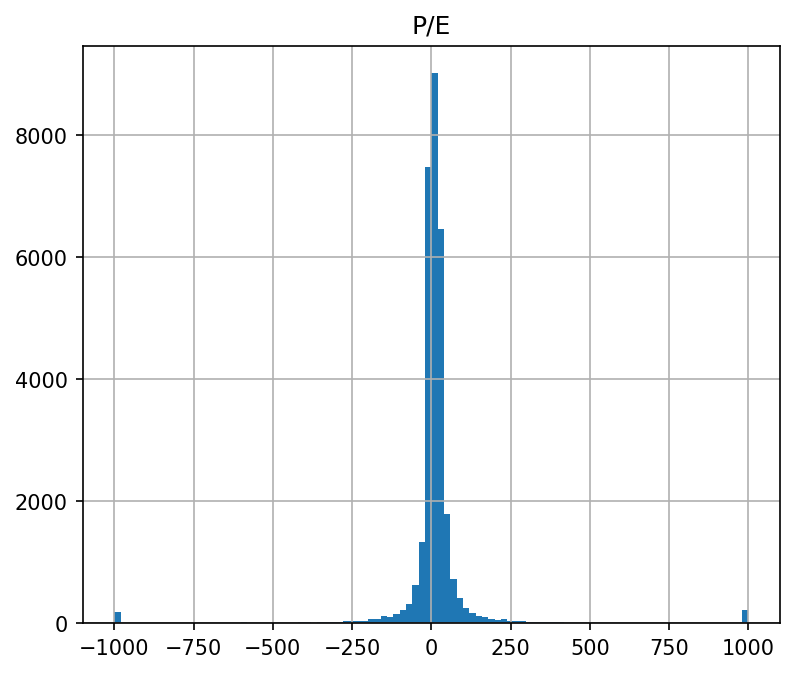

In [17]:
# See one of the distributions
k=X.keys()[2] # Try different numbers, 0-14.
X[k].hist(bins=100, figsize=(6,5))
plt.title(k);

In [18]:
X.describe()

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
count,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000,31053.000000
mean,9.112152,0.066391,11.970881,4.547725,35.204947,-8.302515,3.410715,-0.051593,-0.020468,2.121585,3.261323,2.036428,56.891663,0.363192,0.248916,-0.685477,-0.033789,2.091618
std,89.372217,0.940071,146.115985,13.325608,116.856836,239.591798,4.547047,0.933518,0.416929,6.568524,4.601154,4.161495,290.951374,0.269141,0.305953,2.700742,0.321271,3.409285
min,-500.000000,-5.000000,-1000.000000,-50.000000,0.000000,-600.000000,0.000000,-5.000000,-2.000000,0.000000,0.000000,0.000000,-2000.000000,0.000000,-1.500000,-20.000000,-2.000000,-2.000000
25%,-2.377064,-0.055631,-4.265176,1.245104,0.832075,-4.853041,1.240268,-0.104911,-0.052676,0.381616,1.457220,0.189180,1.463216,0.149896,0.049588,-0.420584,-0.044346,0.457220
50%,11.244620,0.112732,13.058201,2.281609,1.988132,3.234725,1.981859,0.066287,0.062837,0.945783,1.929922,0.607242,5.291840,0.339665,0.205368,0.023803,0.048009,0.929922
75%,21.113367,0.282860,26.193406,4.424847,5.528273,14.823529,3.514311,0.160979,0.140430,1.868171,3.089501,1.805652,12.538014,0.560426,0.429504,0.307201,0.103620,2.089501
max,500.000000,5.000000,1000.000000,100.000000,500.000000,600.000000,30.000000,5.000000,2.000000,100.000000,50.000000,30.000000,2000.000000,1.000000,2.000000,2.000000,1.000000,20.000000


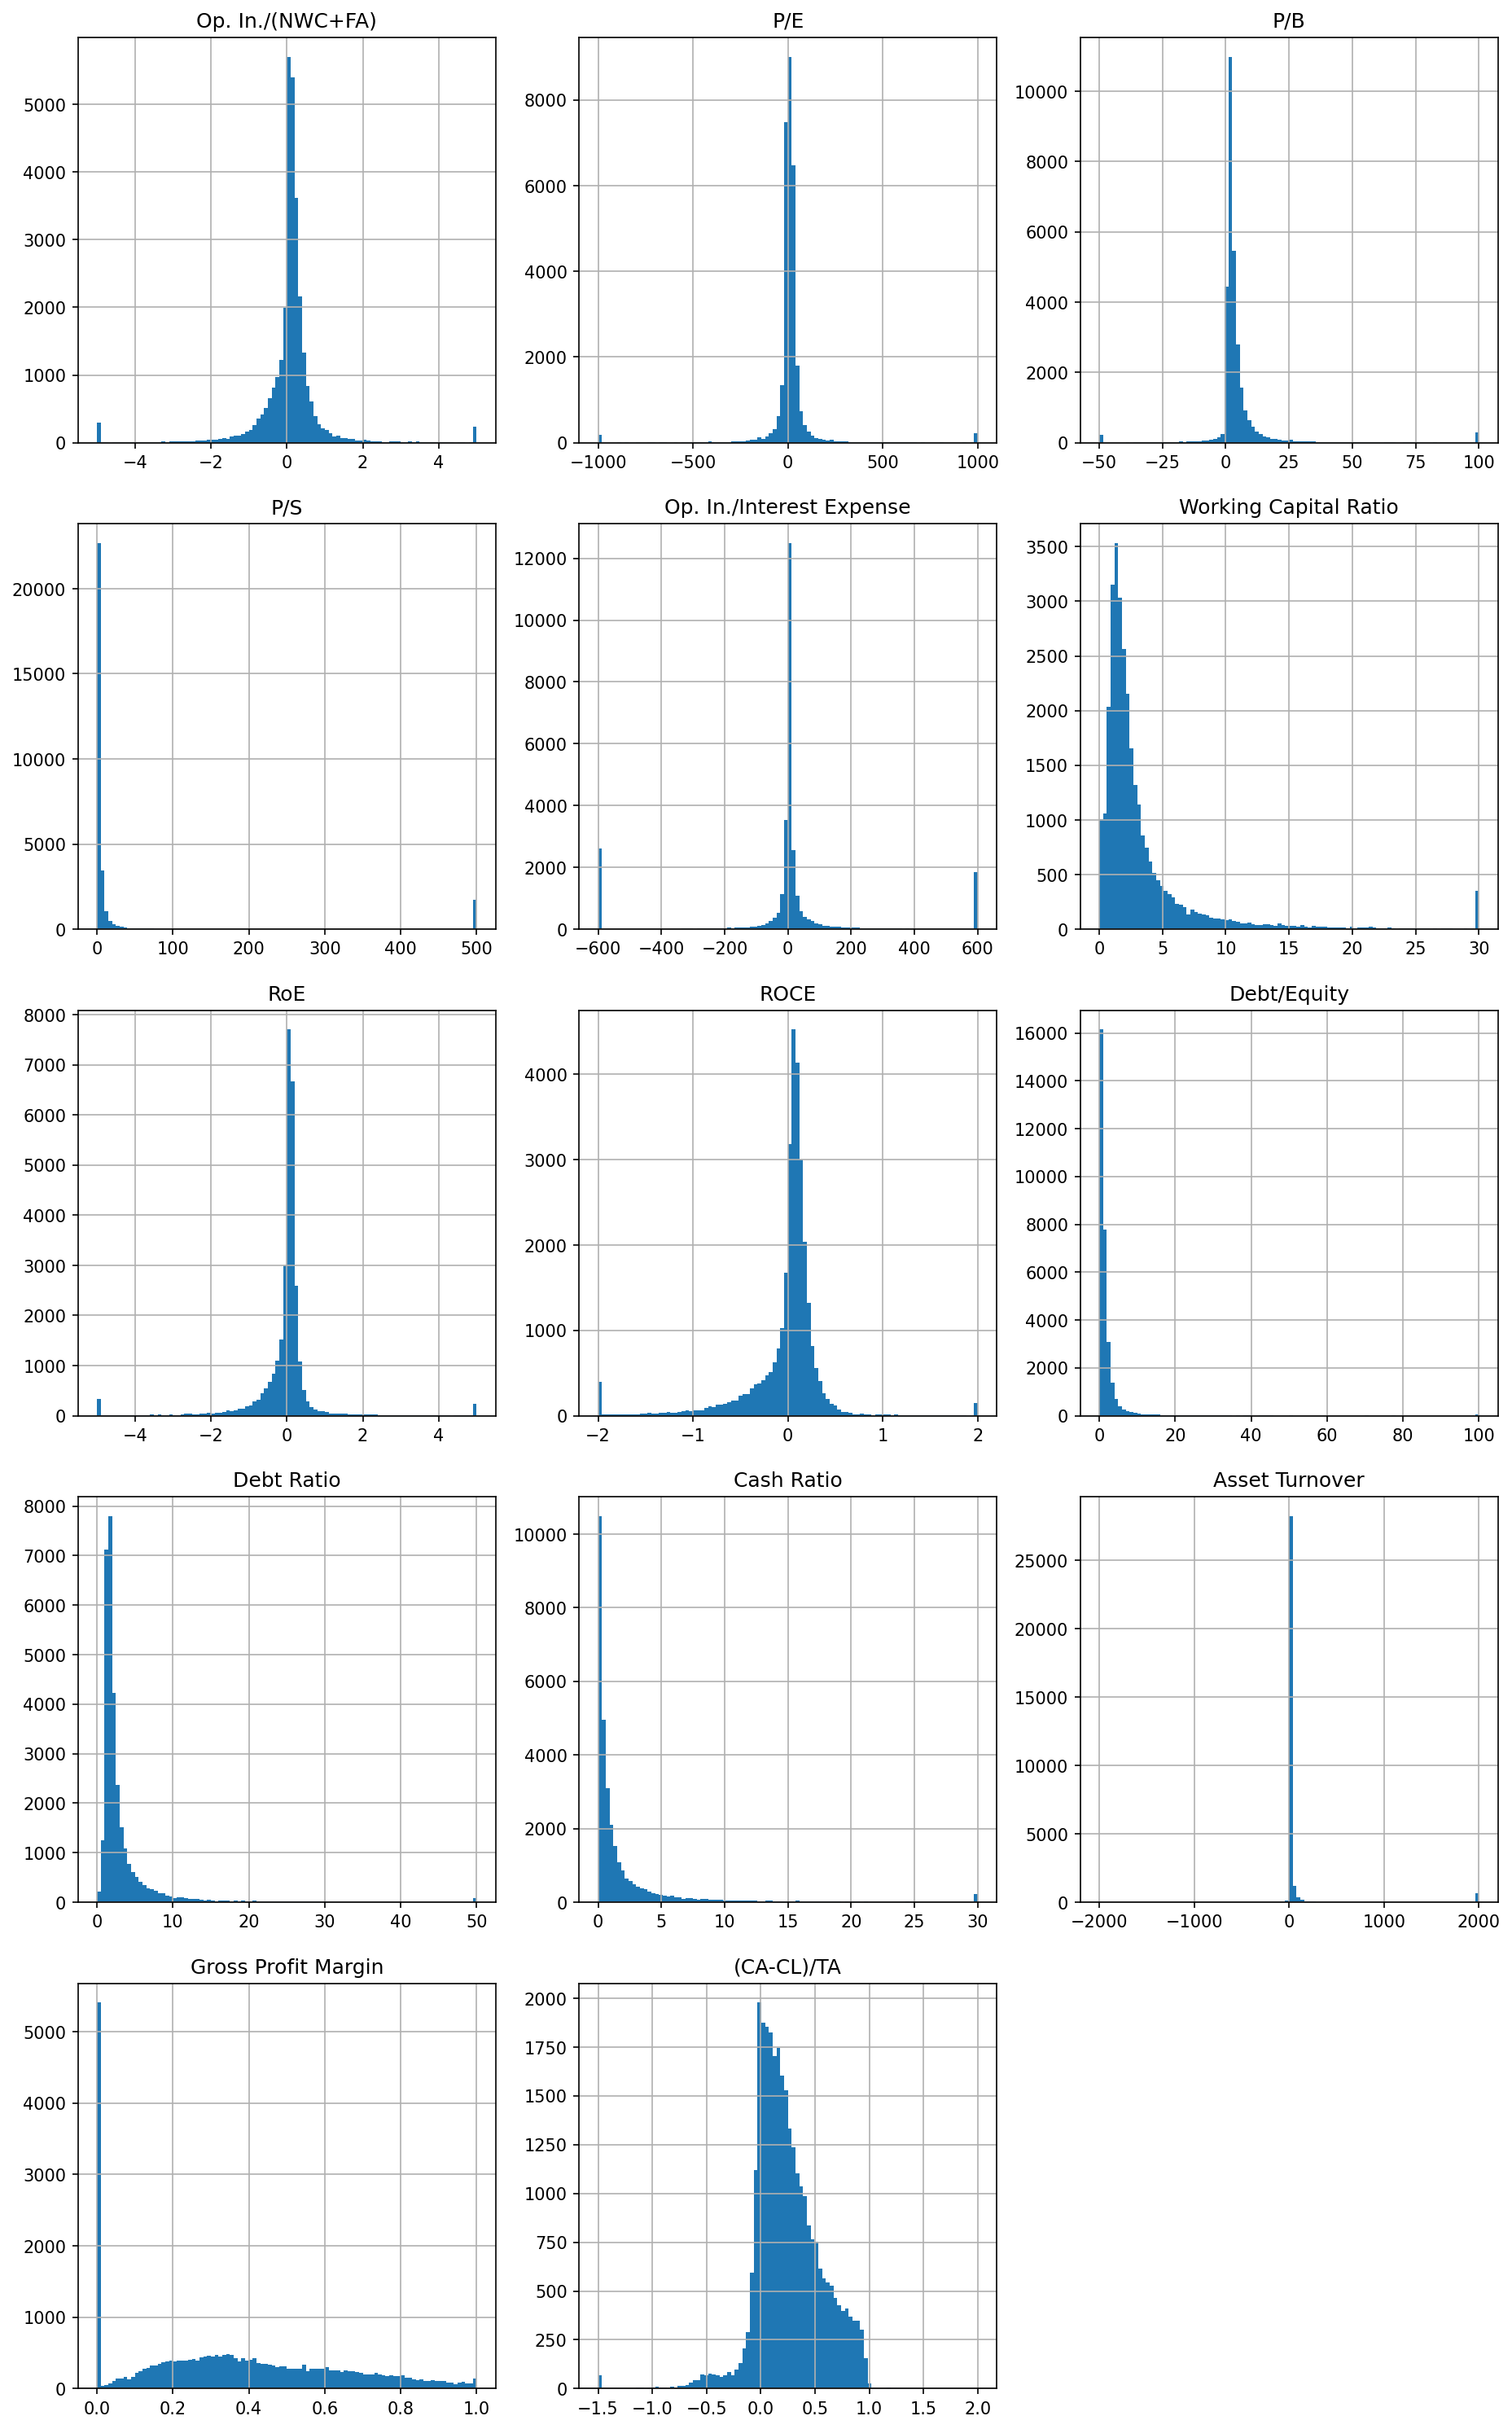

In [19]:
# Make a plot of the distributions.
cols, rows = 3, 5
plt.figure(figsize=(5*cols, 5*rows))

for i in range(1, cols*rows):
    if i<len(X.keys()):
        plt.subplot(rows, cols, i)
        k=X.keys()[i]
        X[k].hist(bins=100)
        plt.title(k);

In [20]:
y.to_csv("Annual_Stock_Price_Performance_Percentage.csv")
X.to_csv("Annual_Stock_Price_Fundamentals_Ratios.csv")

### Try out power transformer see if our data has good distributions
A lot of the algorithms won't work without appropriate transformation. We'll use the power transformer

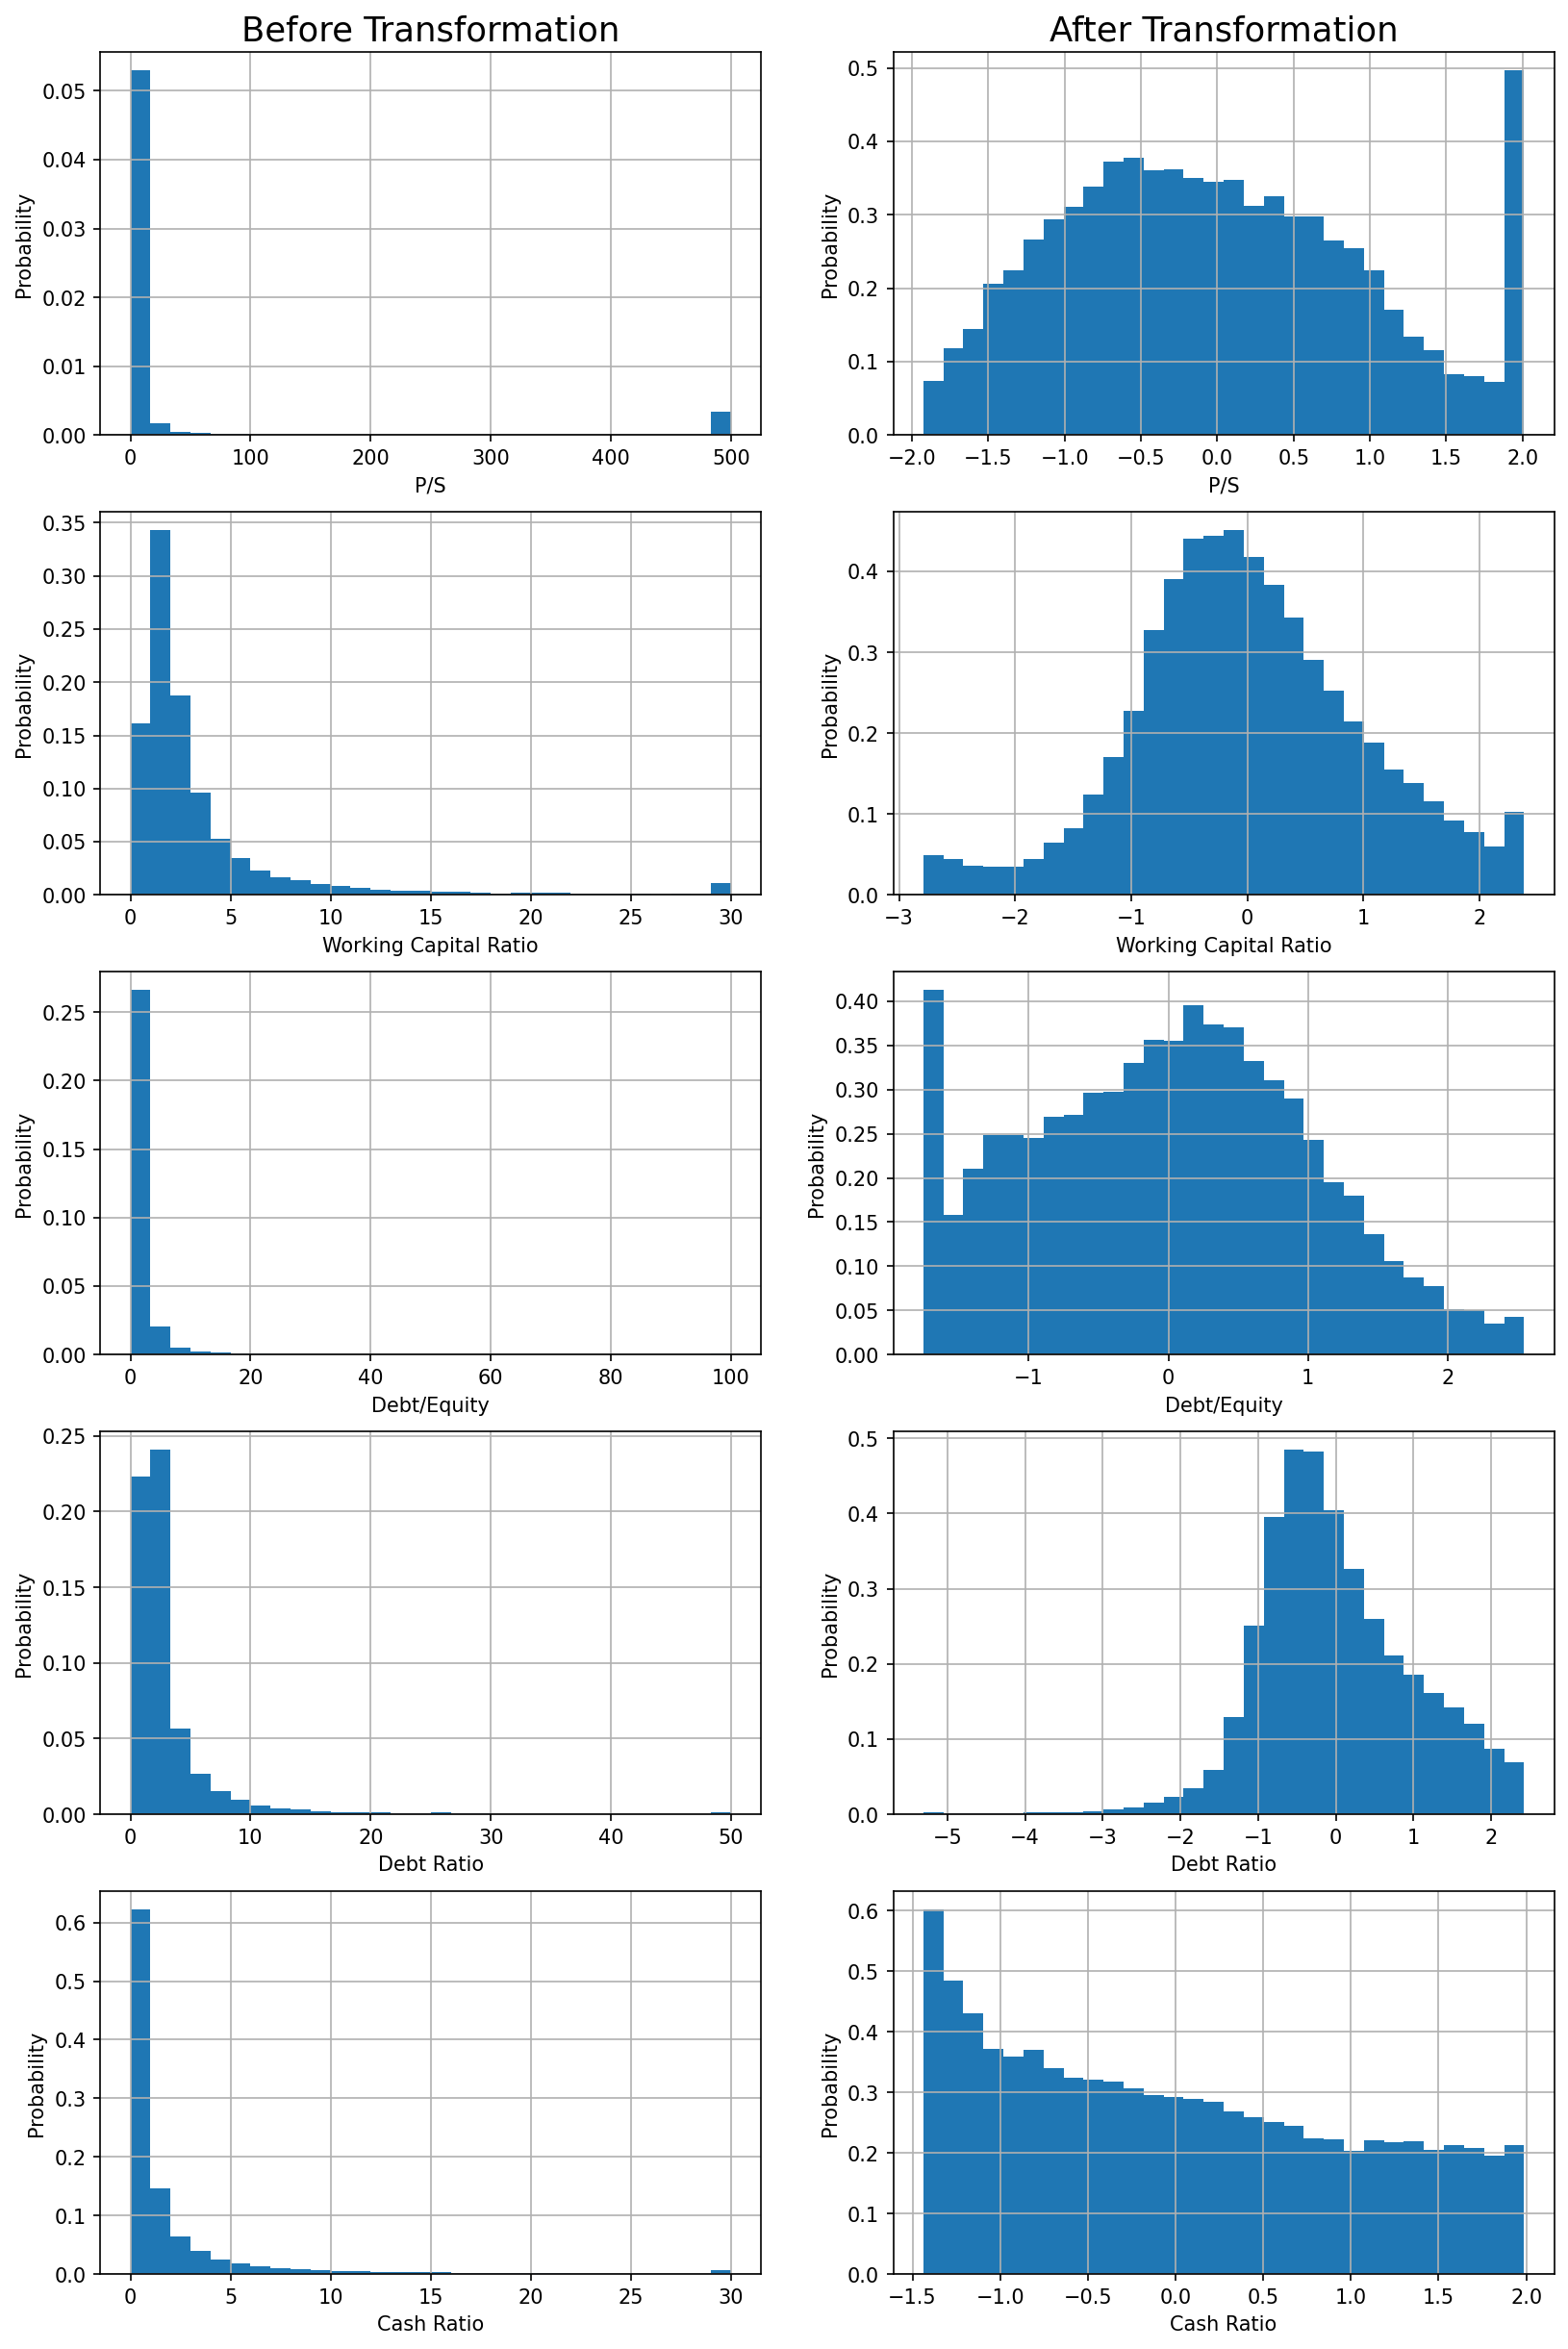

In [21]:
# Write code to plot out all distributions of X in a nice diagram
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer()
X_t=pd.DataFrame(transformer.fit_transform(X), columns=X.keys())

def plotFunc(n, myDatFrame):
    myKey = myDatFrame.keys()[n]
    plt.hist(myDatFrame[myKey], density=True, bins=30)
    plt.grid()
    plt.xlabel(myKey)
    plt.ylabel('Probability')

plt.figure(figsize=(13,20))
plotsIwant=[4,6,9,10,11]

j=1
for i in plotsIwant:
    plt.subplot(len(plotsIwant),2,2*j-1)
    plotFunc(i,X)
    if j==1:
        plt.title('Before Transformation',fontsize=17)
    plt.subplot(len(plotsIwant),2,2*j)
    plotFunc(i,X_t)
    if j==1:
        plt.title('After Transformation',fontsize=17)
    j+=1
    
plt.savefig('Transformat_Dists.png', dpi=300)

# X Data for Final Stock Selection 2024/2023
Requires SimFin PROBulk Download

In [19]:
X=pd.read_csv("Annual_Stock_Price_Fundamentals_Filtered_2024_present.csv", 
              index_col=0)

# Net Income fix, checked annual reports.
X['Net Income (Common)'] = X['Net Income_x'] 

fixNansInX(X)
addColsToX(X)
X=getXRatios(X)
fixXRatios(X)
X.to_csv("Annual_Stock_Price_Fundamentals_Ratios_2024.csv")

In [20]:
X

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
0,-17.434366,-0.019485,-8.175422,0.910556,0.504426,-1.485981,1.453795,-0.111377,-0.031910,1.421728,1.703369,0.311551,1.555048,0.069946,0.097139,-0.091346,-0.025079,0.703369
1,13.222646,0.169826,12.222116,-1.931292,0.190319,2.577220,0.653978,-0.158016,0.063231,0.000000,0.923791,0.365152,1.715902,0.260400,-0.113879,-0.121935,0.042421,-0.076209
2,-10.192166,-0.140144,-7.340887,1.914851,1.890419,-4.688627,2.216408,-0.260847,-0.151682,0.811271,2.232634,0.582541,1.086508,0.270719,0.243403,-0.681206,-0.121330,1.232634
3,27.778943,0.044530,31.564828,1.378354,3.604494,1.881541,1.476253,0.043667,0.039367,1.587107,1.630077,1.351905,0.163102,0.730710,0.009783,0.000000,0.038558,0.630077
4,20.216873,-0.008952,-4.419770,1.491508,0.410912,-0.097853,2.469197,-0.337463,0.026877,5.436181,1.183953,0.782297,1.934445,0.299119,0.148088,-0.342953,0.024168,0.183953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,0.000000,-0.674520,0.000000,0.000000,0.000000,31.135979,4.659101,-0.773457,-0.673514,0.486447,3.055737,3.041028,0.000000,0.000000,0.775388,-1.404860,-0.530792,2.055724
1594,0.000000,-0.577154,0.000000,0.000000,0.000000,600.000000,7.259014,-0.668032,-0.607048,0.261315,4.826793,6.961797,0.000000,0.000000,0.786983,-1.610613,-0.530720,3.826793
1595,0.000000,0.415460,0.000000,0.000000,0.000000,12.841004,2.936574,0.469645,0.262164,1.862352,1.536955,0.944907,2.666667,0.700257,0.292804,0.720636,0.222526,0.536955
1596,0.000000,-0.194041,0.000000,0.000000,0.000000,18.395514,3.925230,-0.177260,-0.112560,0.880541,2.135665,2.062198,9.673023,0.320839,0.366419,0.265110,-0.098460,1.135665
